In [1]:
#GPU 사용하는 만큼만 사용
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

## Module call

In [2]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import skimage.io

import os
import cv2
import random

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM,GRU, Dense, Lambda, Activation, BatchNormalization, Dropout, ZeroPadding2D, Add
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow import keras

from pathlib import Path
from collections import Counter

from tensorflow.keras import layers

## Function define

In [3]:
def df_to_list(df,img_path,max_size):
    """
        df : 데이터 프레임
        img_path : 이미지 있는 경로들
        max_size : resize 할 이미지 사이즈, (width, height) 순으로 들어가야 함
    """
    
    dataset_id_list = df[['name', 'ans']]
    dataset_id_list = dataset_id_list.values.tolist()
    
    # 사진은 X 값을 Y에 저장
    X = []
    Y = []
    
    #image to array
    for name, ans  in tqdm(dataset_id_list):
        image_dir = img_path + name
        img = cv2.imread(image_dir)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = (img/255.)
        img = cv2.resize(img, dsize=max_size, interpolation=cv2.INTER_AREA)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = img.reshape(max_size[1] ,max_size[0],1)
        X.append(img)        
        img_ans = np.array(ans)
        img_ans = img_ans.tolist()
        Y.append(img_ans)  
    
    #numpy change
    X = np.array(X, dtype = np.float32)
    Y = np.array(Y)
    
    return X, Y

In [4]:
def is_valid_char(text):
    for ch in text:
        if not ch in characters:
            return False
    return True

class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=540,
                 img_height=54,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            
            # 3. Get the correpsonding label
            text = self.labels[idx]
            
            # 4. Include the pair only if the captcha is valid
            if is_valid_char(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                for index, val in enumerate(label):
                    batch_labels[j][index] = val
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

## Value define

In [5]:
#csv call
groups_folder_path = '/home/workspace/data/.train/.task157/train/'
df = pd.read_csv('/home/workspace/data/.train/.task157/train/train.csv',sep=',')
# datasetcsv

# ans 항목 NaN값인 애들 제거
index_nan = df[df['ans'].isnull() == True].index
df.drop(index_nan, inplace=True)
df.reset_index(drop=True, inplace=True)


# Store all the characters in a set
characters = set()

for vals in list(df['ans']):
    for ch in vals:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)
print(f"characters len : {len(characters)}")

char_to_labels = {char:idx for idx, char in enumerate(characters)}
labels_to_char = {val:key for key, val in char_to_labels.items()}

characters len : 458


In [6]:
# Batch size for training and validation
batch_size = 30

# Desired image dimensions
img_width=540
img_height=54 

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any captcha in the data
max_length=28

## Model define

In [7]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss



def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height,1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    
    x = layers.Conv2D(32,
               (3,3),
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(1024, activation='relu', name='dense1')(x)
    x = BatchNormalization(name='batchnorm1')(x)
    x = layers.Dropout(0.2)(x)
    
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(512,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(256,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    
    # Predictions
#     x = BatchNormalization(name='batchnorm3')(x)
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    opti = keras.optimizers.Adam(lr=0.0001, epsilon=0.001,decay=1e-5, clipnorm=1.)
#     sgd = keras.optimizers.SGD(learning_rate=0.002,decay=1e-6,momentum=0.9,nesterov=True,clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=opti)
    
    
    return model

## Model load

In [8]:
model = build_model()
model.load_weights("Fold_3_model_v11_6.92.h5")
model.summary()

prediction_model = keras.models.Model(
    model.get_layer(name="input_data").input,
    model.get_layer(name="dense2").output
)

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 540, 54, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 540, 54, 32)  320         input_data[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 540, 54, 32)  128         Conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 540, 54, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Predict

In [10]:
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [11]:
#test data call and generator
test_img_path = '/home/workspace/data/.train/.task157/test/'
test_df = pd.read_csv('/home/workspace/data/.train/.task157/test/test.csv',sep=',')
test_df['ans'] = 'space'

max_size = (540,54)
test_x, test_y = df_to_list(test_df, test_img_path, max_size)
test_data_generator = DataGenerator(data=test_x,
                                         labels=test_y,
                                         char_map=char_to_labels,
                                         batch_size=batch_size,
                                         img_width=img_width,
                                         img_height=img_height,
                                         downsample_factor=downsample_factor,
                                         max_length=max_length,
                                         shuffle=False
                                        )

In [12]:
result_texts = []
#  Let's check results on some validation samples
for p, (inp_value, _) in tqdm(enumerate(test_data_generator)):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    result_texts.extend(pred_texts)
    
version = '11'
test_df['ans'] = result_texts
prediction_path = f'submission_OCR_v{version}.csv'
test_df.to_csv(prediction_path,header=None,index=None)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.



## Submit prediction data

In [15]:
#결과 제출
from nipa.taskSubmit import nipa_submit
import os

team_id = '1150'
task_no = '157'
print(f"prediction csv is : {prediction_path}")
print("is file: ", os.path.isfile(prediction_path))

prediction csv is : submission_OCR_v11.csv
is file:  True


In [16]:
nipa_submit(team_id=team_id,
task_no=task_no,
result=prediction_path
)

20201115104352166816_LRGB.csv: 200


## Check prediction data

예측 결과 :  및 ,납부하지 ,) ,영상진단료 ,방사선치료료 ,53,978 ,3,238,485 ,할인액 ,재활 ,국민인카드 ,105,020 ,통장입금 ,호 ,400,000 ,선 ,PET진단료 ,300,000 ,보철교정료 ,기타 ,265,928 ,66,482 ,정액 ,급수처리 ,조정금액 ,8 ,8 ,7,22,070 ,③ ,④ ,상한액 ,[ ,[√]무 ,요양기관 ,[ ,사업자등록번호 ,사업상 ,소재지 ,2019년 ,24일 ,설명 ,4 ,2. ,있습니다. ,수증.kr) ,안한 비용의 타당성 여부 ,금영수증(지출증)은 ,진료항목 ,있으여 ,진료 ,시 ,있습니다. ,야간(공휴일)진료 ,질병군(DRG)번호 ,안과 ,금액산정내용 ,본인부담 ,선택 ,본인부담 ,료 ,10,983 ,0 ,0 ,15,800 ,료 ,0 ,0 ,식대 ,0 ,0 ,0 ,

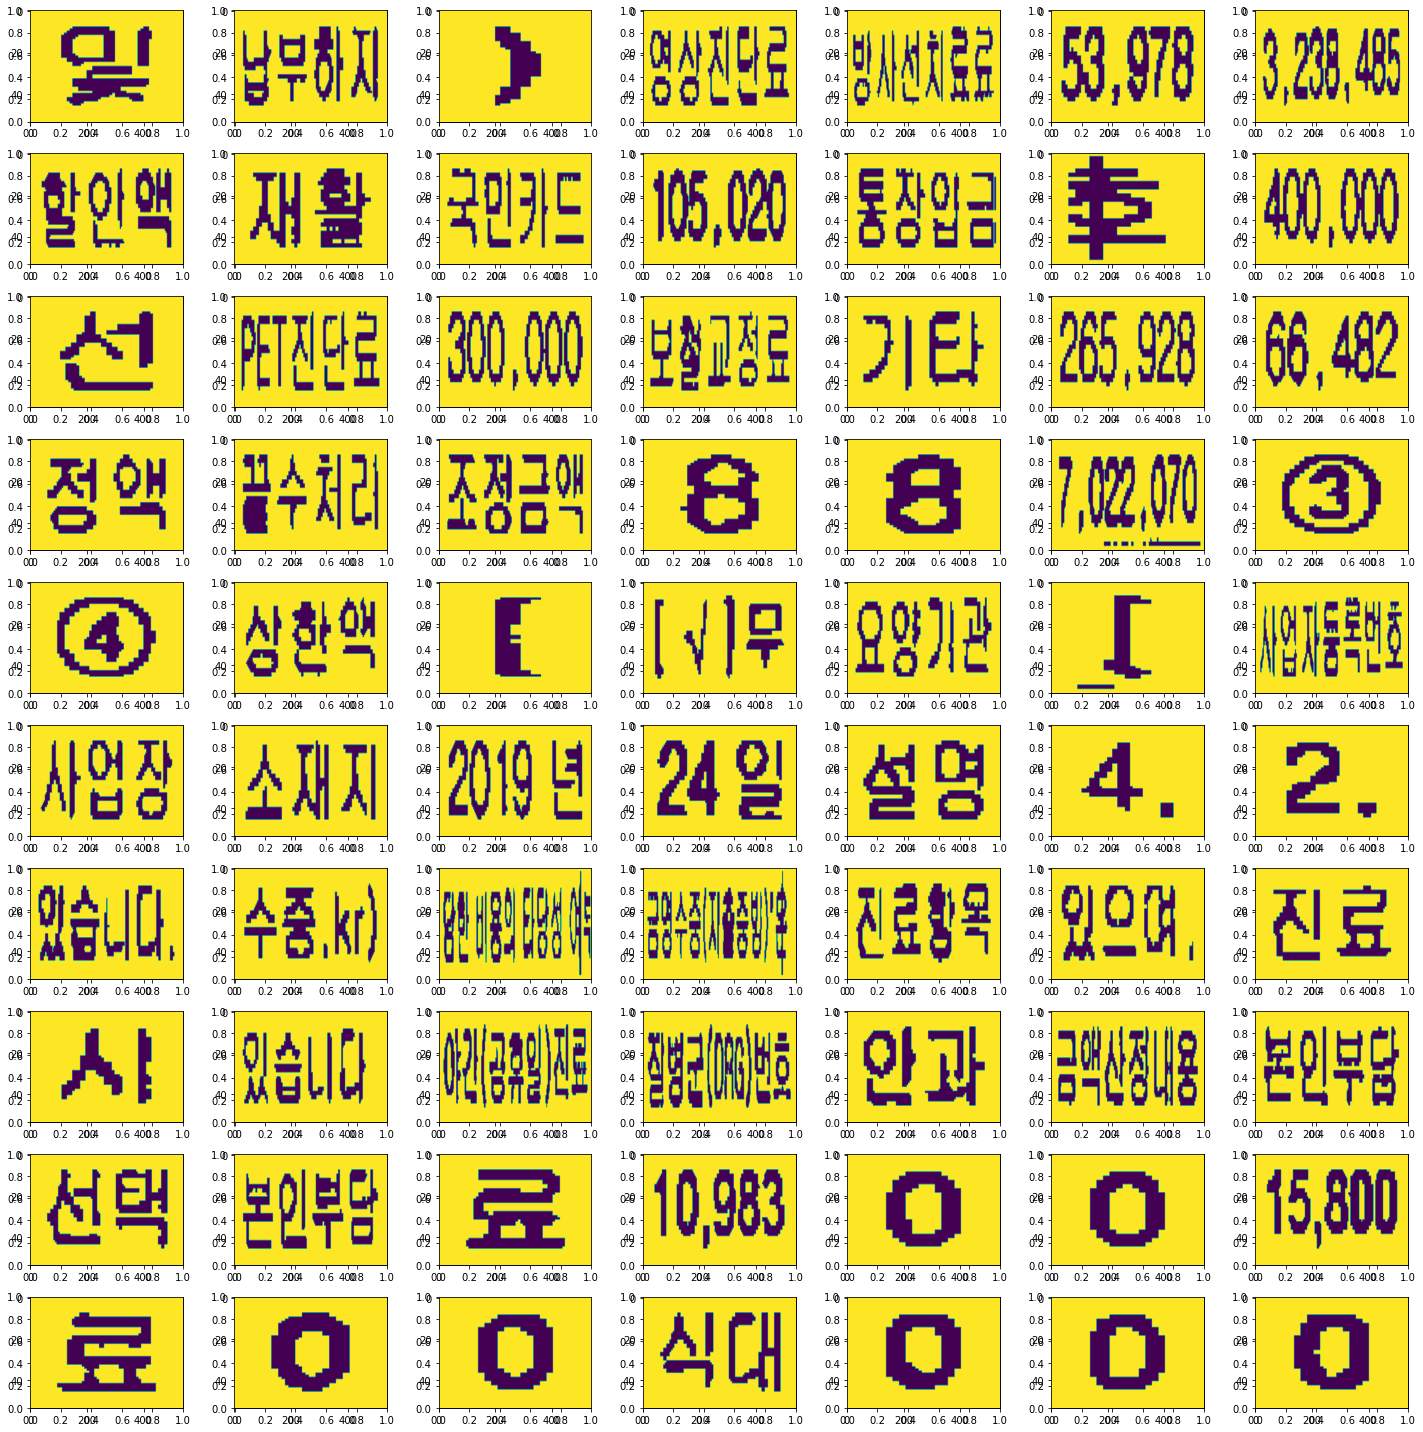

In [14]:
# 예측 확인
rows = 10
cols = 7
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
fig.tight_layout()
i = 1
print(f"예측 결과 : ", end=' ')
for index in range(40,110):
    ax = fig.add_subplot(rows, cols, i)
    print(test_df['ans'][index], end=' ,')
    ax.imshow(test_x[index], aspect="auto")
#     ax.set_xlabel(test_df['ans'][index])
#     ax.axis('off')
    i += 1
#     plt.show()
